<a href="https://colab.research.google.com/github/ignaciomz/CH_IM_61195/blob/main/NLP_ReviewsPeliculasEspa%C3%B1ol_IgnacioMartinez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Reseñas de Películas en Español
**Abstracto con Motivación y Audiencia**

Este proyecto tiene como objetivo desarrollar un clasificador de texto basado en reseñas de películas en español utilizando técnicas de procesamiento de lenguaje natural (NLP) y algoritmos de aprendizaje automático. Las reseñas en línea influyen significativamente en la percepción de las películas y en la decisión de los espectadores a la hora de elegir qué mirar. Por ello, resulta fundamental entender cómo los usuarios evalúan las películas y cuáles son los factores que más impactan su opinión.

Se busca generar una herramienta para profesionales de la industria, como productores, distribuidores, gestores de plataformas y profesionales del marketing, quienes pueden beneficiarse de un modelo que clasifique y analice las opiniones de los espectadores. Esto les permitirá detectar patrones de satisfacción o insatisfacción y ajustar sus estrategias en consecuencia.

El proyecto demuestra el poder del procesamiento de lenguaje natural como herramienta para transformar opiniones textuales en conocimiento accionable, aplicable en una industria donde la voz del espectador define el éxito o fracaso de una película.

# Lectura de datos
**Importación de librerias necesarias**

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
!python -m spacy download es_core_news_sm
from tqdm import tqdm
from collections import Counter
from nltk.util import ngrams
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 38.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [34]:
# Descargamos el archivo desde mi repositorio en GitHub
!wget https://raw.githubusercontent.com/ignaciomz/CH_IM_61195/refs/heads/main/reviews_filmaffinity.csv -O reviews_filmaffinity.csv

--2024-12-16 14:14:08--  https://raw.githubusercontent.com/ignaciomz/CH_IM_61195/refs/heads/main/reviews_filmaffinity.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11536979 (11M) [text/plain]
Saving to: ‘reviews_filmaffinity.csv’

reviews_filmaffinit 100%[===================>]  11.00M  60.3MB/s    in 0.2s    

2024-12-16 14:14:08 (60.3 MB/s) - ‘reviews_filmaffinity.csv’ saved [11536979/11536979]



In [35]:
# Vemos las primeras líneas del archivo como texto para identificar las separaciones del CSV
!head reviews_filmaffinity.csv

film_name||gender||film_avg_rate||review_rate||review_title||review_text
Ocho apellidos vascos||Comedia||6,0||3||OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO||La mayor virtud de esta película es su existencia.El hecho de que podamos jugar con los tópicos más extremos de las identidades patrias (la andaluza y la vasca) sin que nadie se escandalice ni ponga el grito en el cielo, indica mucho de nuestra madurez como nación (pese a quien pese). Bueno, corrijo: el hecho de que podamos jugar y hacer mofa y befa de los tópicos sobre los vascos y el nacionalismo vasco, sin que nadie se escandalice ni ponga el grito en el cielo, indica mucho del grado de normalización de ciertas cuestiones que antes eran llagas abiertas siempre dispuestas a sangrar. Y hago esta corrección, porque los andaluces han sido motivo de guasa siempre y nunca ha pasado nada.Por esto mismo, el planteamiento de "Ocho Apellidos Vascos" es valiente, es oportuno y es oportunista. Seguramente sea esa una de las principales 

In [36]:
# Leemos el archivo CSV con delimitador `||` y especificar las comillas
df = pd.read_csv(
    "reviews_filmaffinity.csv",
    sep=r"\|\|",
    engine="python",
    quotechar='"',
    skip_blank_lines=True,
    on_bad_lines="skip"
)

df.head(20)

,film_name,gender,film_avg_rate,review_rate,review_title,review_text
0,Ocho apellidos vascos,Comedia,"6,0",3.0,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO,La mayor virtud de esta película es su existen...
1,Ocho apellidos vascos,Comedia,"6,0",2.0,El perro verde,"No soy un experto cinéfilo, pero pocas veces m..."
2,Ocho apellidos vascos,Comedia,"6,0",2.0,Si no eres de comer mierda... no te comas esta...,Si no eres un incondicional del humor estilo T...
3,Ocho apellidos vascos,Comedia,"6,0",2.0,Aida: The movie,"No sé qué está pasando, si la gente se deja ll..."
4,Ocho apellidos vascos,Comedia,"6,0",2.0,UN HOMBRE SOLO (Julio Iglesias 1987),"""Pero cuando amanece,y me quedo solo,siento en..."
5,Ocho apellidos vascos,Comedia,"6,0",8.0,"Pues si para ti es una mierda, ¿para qué te la...",La llegada de Rafa a Euskadi es como ponerse a...
6,Ocho apellidos vascos,Comedia,"6,0",3.0,"¿LA MÁS TAQUILLERA? ASÍ NOS VA, ESTO ES LO QU...",El nivel del cine y lo peor la capacidad intel...
7,Ocho apellidos vascos,Comedia,"6,0",3.0,España como imposibilidad,Es triste ver una película como ésta y escucha...
8,Ocho apellidos vascos,Comedia,"6,0",1.0,"¿Que le pasa al público español? ¡ah si, Telec...",Puedo entender que Torrente I y II y Lo imposi...
9,Ocho apellidos vascos,Comedia,"6,0",1.0,"AHIVALAOSTIA, PISHA","-Ahivalohostia, Txomin, qué montón de gente ri..."


In [37]:
# Vemos información del DataSt
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   film_name      8603 non-null   object 
 1   gender         8603 non-null   object 
 2   film_avg_rate  8603 non-null   object 
 3   review_rate    8601 non-null   float64
 4   review_title   8603 non-null   object 
 5   review_text    8603 non-null   object 
dtypes: float64(1), object(5)
memory usage: 403.4+ KB


In [38]:
df.shape

(8603, 6)

# Un poco de EDA
**Obsevermos nuestros datos**

Text(38.27944444444444, 0.5, 'Nº Votos')

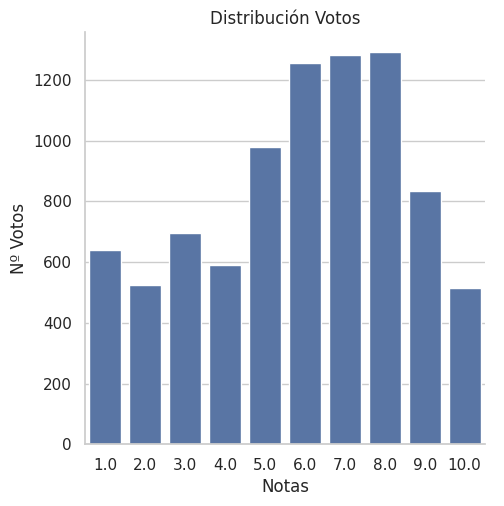

In [39]:
# Veamos la distribución de nuestros datos

sns.catplot(x='review_rate', kind='count', color='b', data=df)
plt.title('Distribución Votos')
plt.xlabel('Notas')
plt.ylabel('Nº Votos')

In [40]:
# Ok, dada la distribución asignaremos etiquetas con criterios según su puntaje recibido.
# Por una cuestión de mejorar la precisión y el equilibrio del peso de los datos, asignamos 2 variables, Positivo o Negativo, según la puntuación obtenida.

df['polaridad'] = df['review_rate'].apply(lambda x: 'positivo' if x > 6 else 'negativo')
df.sample(10)

,film_name,gender,film_avg_rate,review_rate,review_title,review_text,polaridad
1750,Ágora,Aventuras,"6,5",10.0,Ágora. La luz del conocimiento.,Si algo hace grande al Hombre como especie y l...,positivo
8406,La isla mínima,Cine negro,"7,2",8.0,El crimen de las marismas,"Buen thriller, con altibajos en parte de su de...",positivo
6207,Regresión,Thriller,"5,3",5.0,Amenábar decepciona,"Los directores con nombre, que son reconocidos...",negativo
3286,Palmeras en la nieve,Drama,"6,0",2.0,UNA Y NO MÁS SANTO TOMÁS,Hace algún tiempo me leí el libro como estrate...,negativo
4778,Atrapa la bandera,Animación,"5,4",6.0,“El fracaso no es una opción”,Esta nueva película de Enrique Gato (responsab...,negativo
7476,REC,Terror,"6,6",8.0,No dejes de grabar,Estamos sin duda ante una de las propuestas má...,positivo
592,Lo imposible,Drama,"6,8",10.0,No solo es solo una historia sobre los protago...,En mi opinión lo imposible es enormemente conm...,positivo
2769,Torrente 4,Comedia,"4,2",7.0,¿Y que os esperabais?,A ver tengo una cosa que deciros a todos los q...,positivo
3664,Alatriste,Aventuras,"5,5",4.0,Sin un buen guión no hay nada que hacer,"Es una lástima tanta y tan buena producción, t...",negativo
1768,Ágora,Aventuras,"6,5",7.0,Duras críticas para la obra española del año,"Ágora, a pesar de las críticas, es de lo que n...",positivo



Cantidad exacta de reviews:
polaridad
negativo    4683
positivo    3920
Name: count, dtype: int64


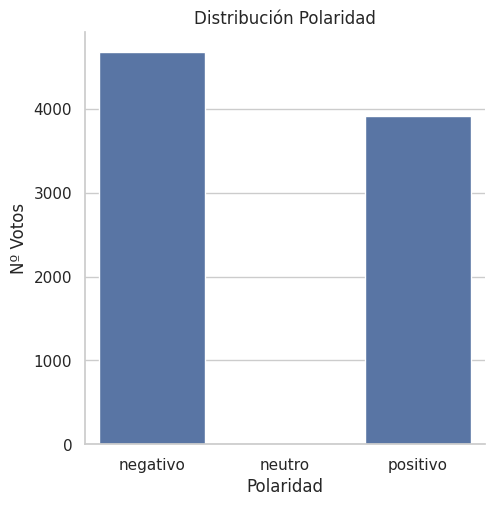

In [41]:
# Ahroa veamos la nueva distribución

sns.catplot(x='polaridad', kind='count', data=df,  order=['negativo', 'neutro', 'positivo'])
plt.title('Distribución Polaridad')
plt.xlabel('Polaridad')
plt.ylabel('Nº Votos')

print("\nCantidad exacta de reviews:")
print(df['polaridad'].value_counts())

In [42]:
# Unimeros el titulo de la review y el texto ya que peude aportarnos información.

df['texto'] = df['review_title'] + ' ' + df['review_text']
df.head(5)

# Ahora obtendremos dos columnas nuevas, 'polaridad' y 'texto' que serán nuestra (y,x)

,film_name,gender,film_avg_rate,review_rate,review_title,review_text,polaridad,texto
0,Ocho apellidos vascos,Comedia,"6,0",3.0,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO,La mayor virtud de esta película es su existen...,negativo,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO...
1,Ocho apellidos vascos,Comedia,"6,0",2.0,El perro verde,"No soy un experto cinéfilo, pero pocas veces m...",negativo,"El perro verde No soy un experto cinéfilo, per..."
2,Ocho apellidos vascos,Comedia,"6,0",2.0,Si no eres de comer mierda... no te comas esta...,Si no eres un incondicional del humor estilo T...,negativo,Si no eres de comer mierda... no te comas esta...
3,Ocho apellidos vascos,Comedia,"6,0",2.0,Aida: The movie,"No sé qué está pasando, si la gente se deja ll...",negativo,"Aida: The movie No sé qué está pasando, si la ..."
4,Ocho apellidos vascos,Comedia,"6,0",2.0,UN HOMBRE SOLO (Julio Iglesias 1987),"""Pero cuando amanece,y me quedo solo,siento en...",negativo,"UN HOMBRE SOLO (Julio Iglesias 1987) ""Pero cua..."


In [43]:
print("\nValores faltantes por columna:")
print(df.isnull().sum())


Valores faltantes por columna:
film_name        0
gender           0
film_avg_rate    0
review_rate      2
review_title     0
review_text      0
polaridad        0
texto            0
dtype: int64


In [44]:
# Instanciemos nuestra X e Y

X = df['texto'].values
y =  df['polaridad'].values

# Un poco de Data Wrangling
**Manipulando nuestros datos**

In [45]:
# Bien, comencemos con la normalización.
# Usaremos spaCY y en un mismo codigo, haremos lematización, eliminaremos StopWords y signos gramaticales, eliminaremos palabras menores a 3 caracteres y mayores a 11, y filtraremos categorías gramaticales.
# Cargar modelo en español de spaCy
# !python -m spacy download es_core_news_sm

nlp = spacy.load('es_core_news_sm')

def normalize(corpus):

    for index, doc in enumerate(tqdm(corpus, desc="Normalizando texto")):
        doc = nlp(doc.lower())
        corpus[index] = " ".join([
            token.lemma_ for token in doc
            if not token.is_punct
            and 3 <= len(token.text) <= 11
            and not token.is_stop
            and re.sub(r'\s+', ' ', token.text)
            and token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']
        ])
    return corpus

X_norm = normalize(X)

print(X_norm[:5])

Normalizando texto: 100%|██████████| 8603/8603 [06:33<00:00, 21.85it/s]

['apellido vasco nombre virtud película jugar tópico extremo identidad patrio andaluz vasco escandalizar poner grito cielo indicar madurez nación pese pese corrijo jugar mofa tópico vasco vasco escandalizar poner grito cielo indicar grado cuestión llaga abierto dispuesto sangrar corrección andaluz motivo guasa apellido vasco valiente oportuno oportunista seguramente principal razón español acudir masa masa precedente cine producto patrocinado tele acertado fecha estreno verano brutal ejemplar campaña marketing aplaudo celebro.eso celebrar decir repito oscuro placer película mala insistir olvidar principal propósito cine entretener decir mantengo problema apelido vasco malo friki disparatado peli mala"(como sharknado xanadu condemor entretenido perdonar él mediocridad punto palabra define mediocridad mediocre simple sencillo impersonal hecho interesar novedoso sacar elemento entorno totalmente ajeno hostil argumento básico comedia cine cine explicar elemento encajar absoluto película ca

In [46]:
# Veamos las primeras filas del corpus

df_normalized = pd.DataFrame({
    'texto_normalizado': X_norm,
    'polaridad': y
})

print(df_normalized.head())

                                   texto_normalizado polaridad
0  apellido vasco nombre virtud película jugar tó...  negativo
1  perro verde experto cinéfilo sentir juego sala...  negativo
2  comer mierda comar mierda humor estilo termina...  negativo
3  aido pasar gente dejar moda gustar poner rovir...  negativo
4  hombre julio iglesia amanecer quedar sentir fo...  negativo


In [47]:
# Ahora, analicemos la frecuencia de las palabras

texto_completo = ' '.join(df_normalized['texto_normalizado'])
palabras = texto_completo.split()
contador_palabras = Counter(palabras)
df_frecuencia = pd.DataFrame(contador_palabras.items(), columns=['Palabra', 'Frecuencia'])
df_frecuencia = df_frecuencia.sort_values(by='Frecuencia', ascending=False).reset_index(drop=True)
print(df_frecuencia.head(20))


      Palabra  Frecuencia
0    película       19520
1          él        7723
2        cine        6609
3     español        5561
4    historia        5360
5   personaje        4928
6         ver        4741
7       actor        3263
8     momento        3001
9       pasar        2648
10     escena        2592
11      guión        2533
12      dejar        2501
13   director        2363
14       cosa        2262
15     gustar        2253
16     quedar        2007
17        año        2004
18       film        1885
19       malo        1874


In [48]:
# Bien, vamos a utilizar bigramas para mejorar la performance de nuestro clasificador, ya que el corpus contiene gran cantidad de documentos con mucha narrativa.

def generar_bigramas(textos):
    bigramas_lista = []
    for texto in textos:
        tokens = texto.split()
        bigramas = list(ngrams(tokens, 2))
        bigramas_lista.extend(bigramas)
    return bigramas_lista

bigramas = generar_bigramas(df_normalized['texto_normalizado'])

contador_bigramas = Counter(bigramas)

df_bigramas = pd.DataFrame(contador_bigramas.items(), columns=['Bigrama', 'Frecuencia'])

df_bigramas = df_bigramas.sort_values(by='Frecuencia', ascending=False).reset_index(drop=True)

print(df_bigramas.head(20))

                Bigrama  Frecuencia
0       (cine, español)        1887
1             (ver, él)        1262
2   (película, español)         731
3       (ver, película)         460
4       (banda, sonoro)         433
5     (apellido, vasco)         431
6             (dar, él)         415
7       (obra, maestro)         365
8    (efecto, especial)         362
9         (pasar, rato)         351
10       (punto, vista)         339
11      (guerra, civil)         312
12       (isla, mínimo)         302
13          (hacer, él)         286
14        (claro, lago)         275
15    (karra, elejalde)         265
16      (película, ver)         248
17       (dani, roviro)         241
18       (él, película)         225
19    (mejor, película)         223


# Empecemos con la Automatización
**Generando el clasificador**

In [49]:
# Generamos la Bag of Words con bigramas
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=2000)

X_bow = vectorizer.fit_transform(df_normalized['texto_normalizado'])

print("Características más frecuentes (unigramas y bigramas):")
print(vectorizer.get_feature_names_out()[:20])


Características más frecuentes (unigramas y bigramas):
['2004' '2014' 'abajo' 'abandonar' 'abierto' 'abordar' 'abrir' 'abrir ojo'
 'absoluto' 'absurdo' 'abuela' 'aburrido' 'aburrir' 'abusar' 'abuso'
 'acabar' 'acabar película' 'acaso' 'acción' 'acento']


In [50]:
# Preparamos nuestro Train y Test
X_train, X_test, y_train, y_test = train_test_split(X_bow, df['polaridad'], test_size=0.2, random_state=42)


[]

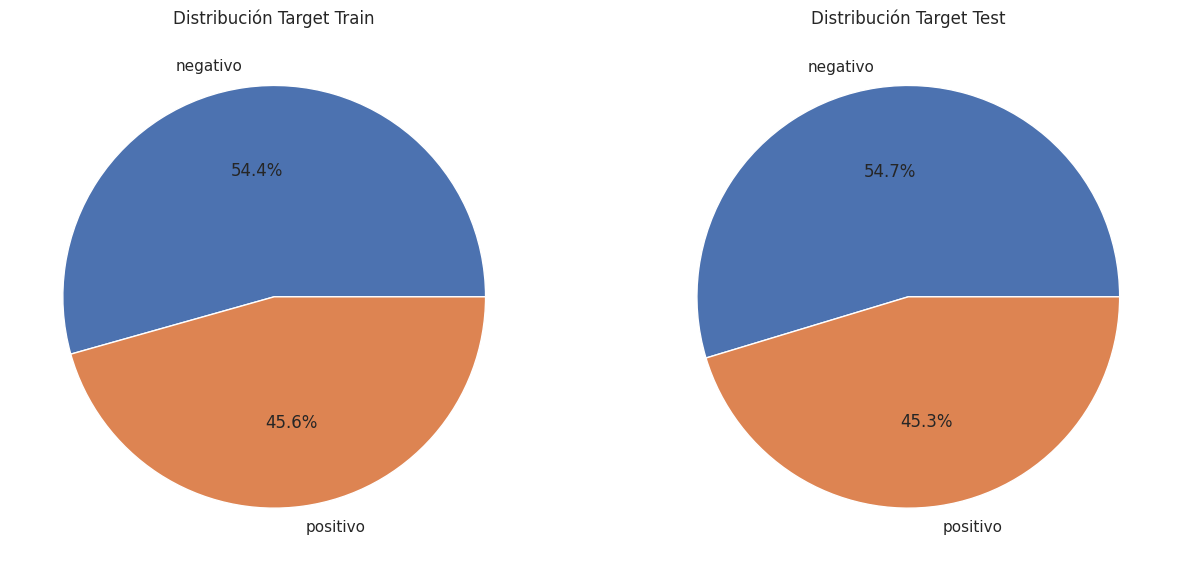

In [51]:
# Visualizamos la composición de nuestra X e Y

keys_train, counts_train = np.unique(y_train, return_counts=True)
keys_test, counts_test = np.unique(y_test, return_counts=True)
perct_train = counts_train / np.sum(counts_train)
perct_test = counts_test / np.sum(counts_test)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.pie(perct_train, labels=keys_train, autopct='%1.1f%%')
plt.title('Distribución Target Train')
plt.subplot(1, 2, 2)
plt.pie(perct_test, labels=keys_test, autopct='%1.1f%%')
plt.title('Distribución Target Test')
plt.plot()

In [52]:
# Listamos los modelos que vamos a utilizar y ahora si, comenzamos!
modelos = {
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

resultados = []
matrices_confusion = {}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    resultados.append([nombre, acc, precision, recall, f1])

    matrices_confusion[nombre] = confusion_matrix(y_test, y_pred)

df_resultados = pd.DataFrame(resultados, columns=["Modelo", "Accuracy", "Precision", "Recall", "F1"])
print(df_resultados)


                Modelo  Accuracy  Precision    Recall        F1
0        MultinomialNB  0.761185   0.761657  0.761185  0.761363
1          BernoulliNB  0.745497   0.744909  0.745497  0.744711
2  Regresión Logística  0.749564   0.749907  0.749564  0.749705
3                  SVM  0.779779   0.779394  0.779779  0.779331
4        Random Forest  0.753632   0.753108  0.753632  0.753073


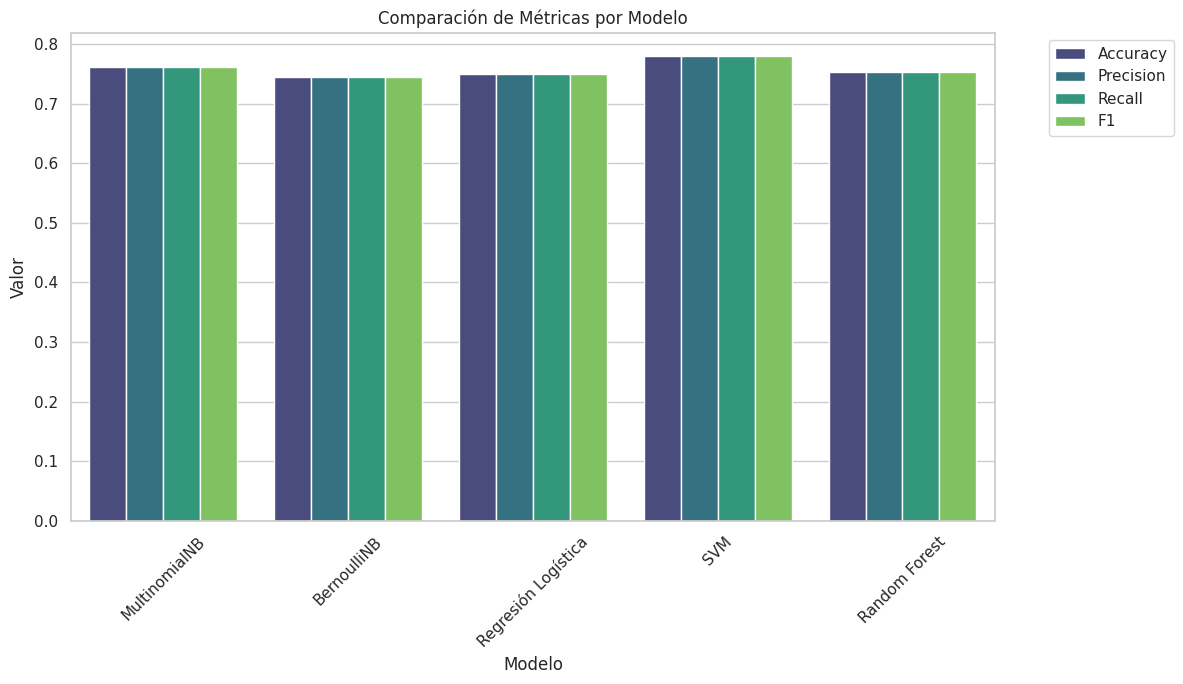

In [53]:
# Vemos que el modelo SVM fue el que mejor performó.
# Pero para tener una visualización mas cómoda, grafiquemos.

sns.set(style="whitegrid")

plt.figure(figsize=(12, 7))
df_resultados_melted = df_resultados.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")

sns.barplot(data=df_resultados_melted, x="Modelo", y="Valor", hue="Métrica", palette="viridis")
plt.title("Comparación de Métricas por Modelo")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


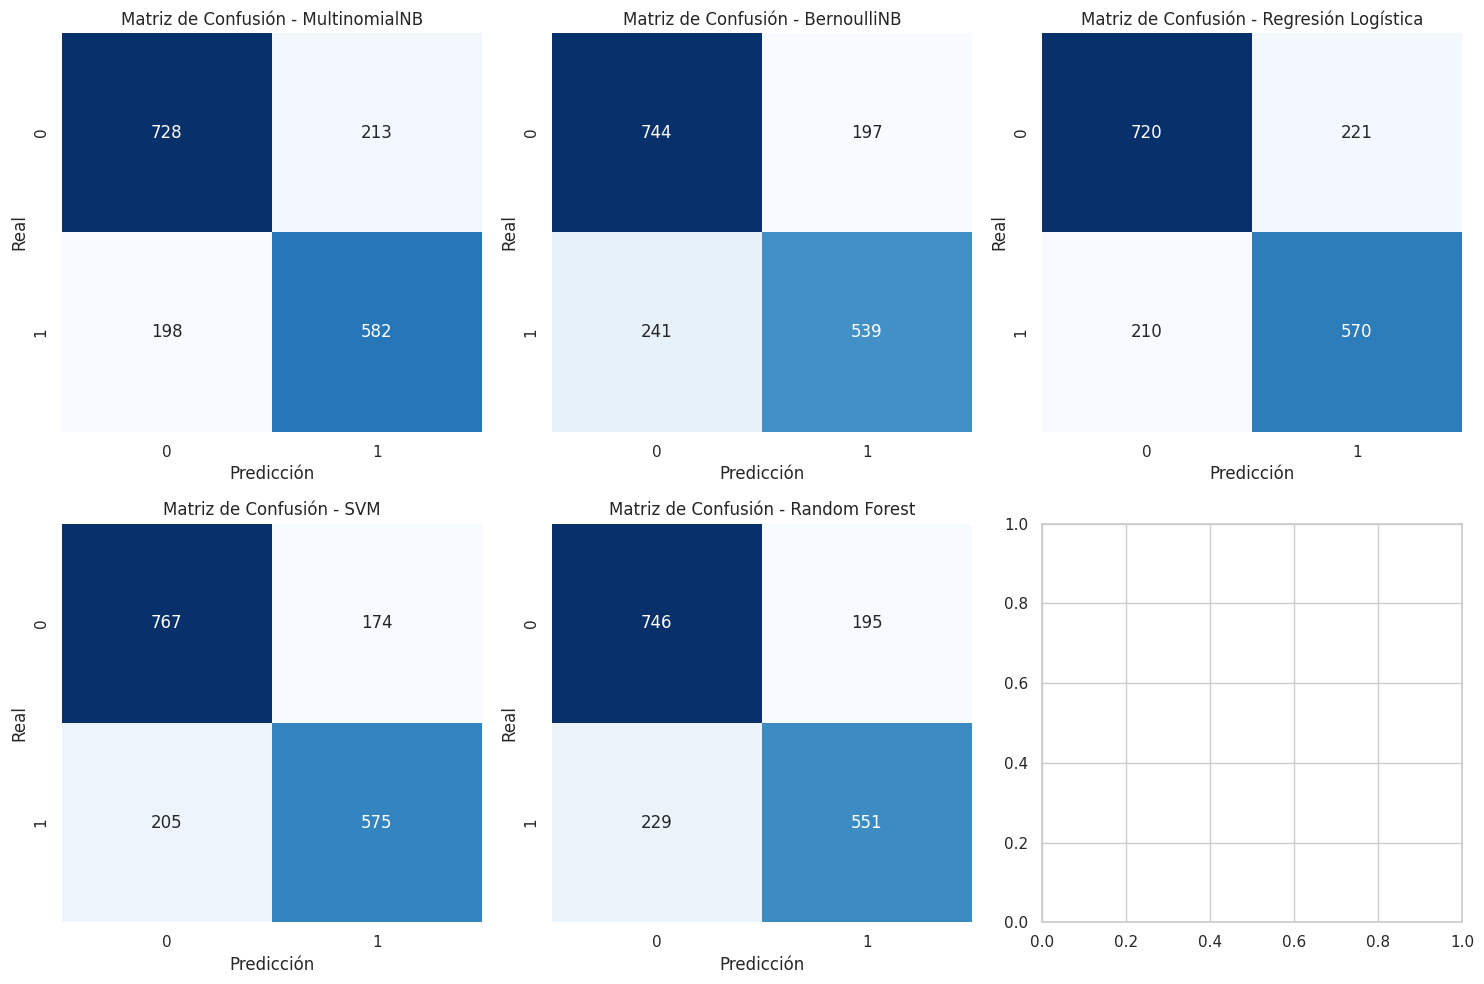

In [54]:
# Grafiquemos las matrices de confusión para contemplarlas

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (nombre, matriz) in enumerate(matrices_confusion.items()):
    sns.heatmap(matriz, annot=True, fmt="d", cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(f"Matriz de Confusión - {nombre}")
    axes[i].set_xlabel("Predicción")
    axes[i].set_ylabel("Real")

plt.tight_layout()
plt.show()


In [55]:
# Intentaremos mejorar los resultados con ayuda de TF-IDF

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=2000)

X_tfidf = tfidf_vectorizer.fit_transform(df_normalized['texto_normalizado'])

y = df_normalized['polaridad']

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

In [56]:
# Ahora, repetimos el proceso.
# Cargamos los modelos, y ejecutamos.

modelos = {
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

resultados_tfidf = []
matrices_confusion_tfidf = {}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    resultados_tfidf.append([nombre, acc, precision, recall, f1])

    matrices_confusion_tfidf[nombre] = confusion_matrix(y_test, y_pred)

df_resultados_tfidf = pd.DataFrame(resultados_tfidf, columns=["Modelo", "Accuracy", "Precision", "Recall", "F1"])
print(df_resultados_tfidf)


                Modelo  Accuracy  Precision    Recall        F1
0        MultinomialNB  0.767919   0.767338  0.767919  0.766859
1          BernoulliNB  0.753196   0.752432  0.753196  0.752236
2  Regresión Logística  0.784192   0.783808  0.784192  0.783913
3                  SVM  0.785742   0.785425  0.785742  0.785531
4        Random Forest  0.751647   0.751072  0.751647  0.751220


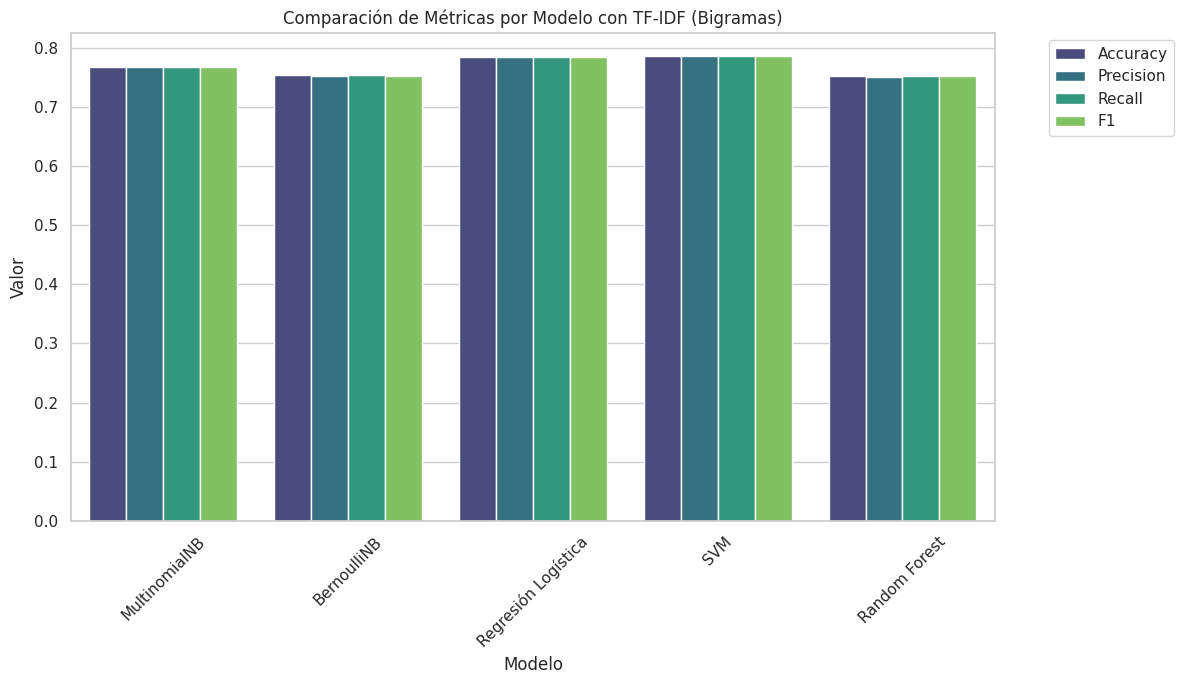

In [57]:
# Vemos que apenas ha mejorado el resultado si miramos SVM
# Grafiquemos para observar el rendimiento habiendo usado TF-IDF

plt.figure(figsize=(12, 7))
df_resultados_tfidf_melted = df_resultados_tfidf.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")

sns.barplot(data=df_resultados_tfidf_melted, x="Modelo", y="Valor", hue="Métrica", palette="viridis")
plt.title("Comparación de Métricas por Modelo con TF-IDF (Bigramas)")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


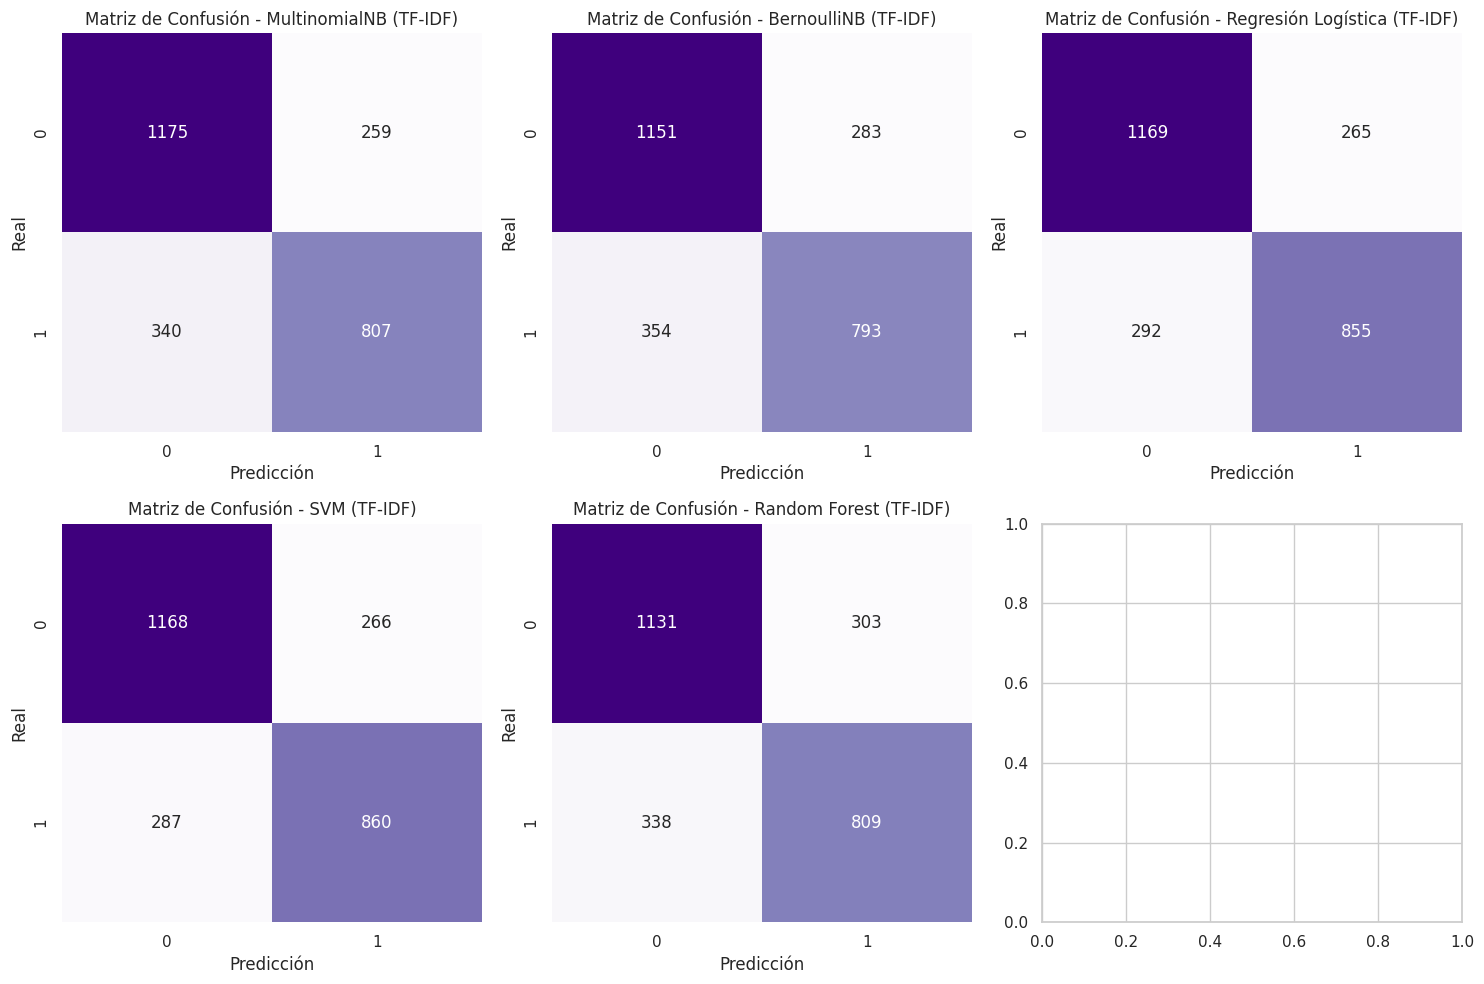

In [58]:
# Graficamos las matrices de confusión

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (nombre, matriz) in enumerate(matrices_confusion_tfidf.items()):
    sns.heatmap(matriz, annot=True, fmt="d", cmap="Purples", ax=axes[i], cbar=False)
    axes[i].set_title(f"Matriz de Confusión - {nombre} (TF-IDF)")
    axes[i].set_xlabel("Predicción")
    axes[i].set_ylabel("Real")

plt.tight_layout()
plt.show()


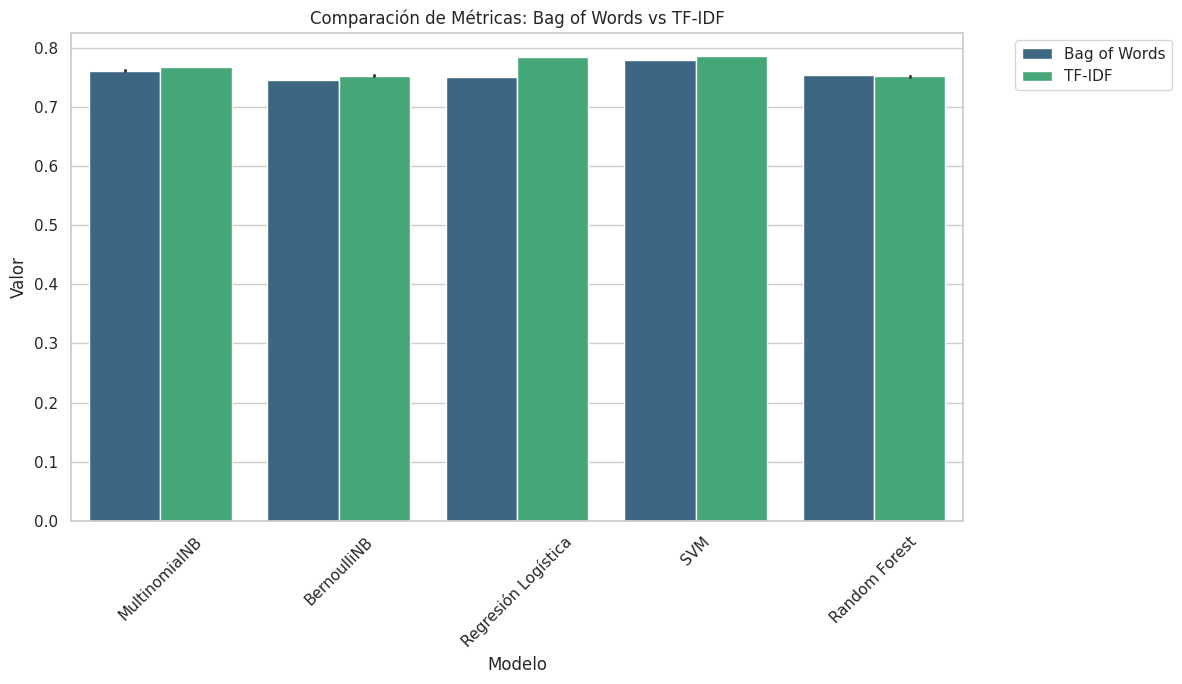

In [59]:
# Comparamos resultados de BoW vs TF-IDF
df_resultados["Vectorización"] = "Bag of Words"
df_resultados_tfidf["Vectorización"] = "TF-IDF"

df_comparativa = pd.concat([df_resultados, df_resultados_tfidf])

# Graficamos la comparativa
plt.figure(figsize=(12, 7))
df_comparativa_melted = df_comparativa.melt(id_vars=["Modelo", "Vectorización"], var_name="Métrica", value_name="Valor")

sns.barplot(data=df_comparativa_melted, x="Modelo", y="Valor", hue="Vectorización", palette="viridis")
plt.title("Comparación de Métricas: Bag of Words vs TF-IDF")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Pongamos a prueba el Clasificador
**Carguemos nuevas reseñas y veamos que sucede**

In [60]:
# Bien, llegó la hora de probar nuestro clasificador.
# Inventamos reseñas, y las probamos en nuestro código.
# Estas son las nuevas reviews, y su clasificación propuesta antes de pasar por el clasificador.
# Veamos que resultado obtenemos.

nuevas_reseñas = [
    "Me encantó la película, la trama fue excelente y los actores estuvieron increíbles. ¡Recomendada totalmente!",  # Positiva
    "Es una película aburrida, los efectos especiales son malos y la historia no tiene sentido. No la recomiendo.",  # Negativa
    "Una de las mejores películas que he visto en años, llena de emoción y con un mensaje muy profundo. ¡Impresionante!",  # Positiva
    "Pésima película, me aburrí desde el principio. No entiendo cómo alguien pudo disfrutarla.",  # Negativa
    "La película fue buena, pero me esperaba más. Los giros de la trama fueron previsibles.",  # Negativa
]

X_nuevas = tfidf_vectorizer.transform(nuevas_reseñas)

svm_model = SVC()
svm_model.fit(X_train, y_train)

predicciones = svm_model.predict(X_nuevas)

for reseña, prediccion in zip(nuevas_reseñas, predicciones):
    sentimiento = 'Positiva' if prediccion == 'positivo' else 'Negativa'
    print(f"Reseña: {reseña}\nClasificación Predicha: {sentimiento}\n")

Reseña: Me encantó la película, la trama fue excelente y los actores estuvieron increíbles. ¡Recomendada totalmente!
Clasificación Predicha: Positiva

Reseña: Es una película aburrida, los efectos especiales son malos y la historia no tiene sentido. No la recomiendo.
Clasificación Predicha: Negativa

Reseña: Una de las mejores películas que he visto en años, llena de emoción y con un mensaje muy profundo. ¡Impresionante!
Clasificación Predicha: Positiva

Reseña: Pésima película, me aburrí desde el principio. No entiendo cómo alguien pudo disfrutarla.
Clasificación Predicha: Negativa

Reseña: La película fue buena, pero me esperaba más. Los giros de la trama fueron previsibles.
Clasificación Predicha: Negativa



# Conclusiones
**El clasificador parece responder bien y podría servir como herramienta primaria para identificar sentimientos Negativos y Positivos sobre películas. Sin embargo, la precisión sigue siendo del 78% y podría fallar en reseñas muy específicas o escuetas. El DataSet de donde obtenemos el Corpus, es complicado por su gran carga léxica, pero el objetivo primario esta cumplido**

Muchas gracias!

Ignacio Martínez